In [1]:
%matplotlib inline

import numpy as np
import sys
from scipy import special, stats
from scipy.optimize import minimize, fminbound
import random
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import pickle

matplotlib.rcParams['figure.figsize'] = (20,10)
matplotlib.rcParams['font.size'] = 22
matplotlib.rcParams['legend.handlelength'] = 2
matplotlib.rcParams['lines.linewidth'] = 3


def grille_Riemann(dim, taille_echantillon):
    """
    Retourne les centres d'hypercubes d'une grille multidimensionnelle
    """
    N = int(taille_echantillon**(1/dim)) # nb de boites par cote, eventuellement arrondi
    delta=2/N
    allG = [np.linspace(-1+delta/2,1-delta/2,num=N) for G in range(dim)]
    mesh = np.meshgrid(*allG)
    ans = list(zip(*(d.flat for d in mesh)))
    if len(ans) != taille_echantillon:
        print("  - Taille d'echantillon ajustee pour la methode de Riemann:"
              ,len(ans),"au lieu de",taille_echantillon,"(dimension =",dim,")")
    return np.array(ans)

def N_effectif(dim, taille_echantillon):
    """
    Retourne le nombre d'hypercubes utilisés lors de la discrétisation
    donne le même résultat que len(grille_Riemann(dim, taille_echantillon))
    mais sans générer la grille
    """
    return (int(taille_echantillon**(1/dim)))**dim

<div class="alert alert-danger">

<b>Ce notebook est à remplir au fur et à mesure du cours et constituera votre rapport sur les trois premières journées de cours. Les questions entourées du symbole $\star$ sont à traiter en dehors du cours.</b></div>

<h1 class="text-center">EISC-211 : Méthodes de Monte-Carlo</h1>

<a id="RIEMANN"></a><h1 style="border: 5px solid; text-align: center; padding: 10px"> I. Calcul du volume d'une sphère par la méthode de Riemann</h1>

<div class="alert alert-success">On montre dans cette partie les limitations des techniques d'intégration en grande dimension. L'exemple de l'estimation du volume d'une sphère sera le fil rouge du cours.</div>

Le volume $V_d$ délimité par la sphère de rayon $1$ en dimension $d$ est donné par l'expression suivante:

$$ V_d = \frac{\pi^{d/2}}{\Gamma(d/2+1)} \mathop{\sim}_{d \to \infty} \frac{1}{\sqrt{\pi d}} \left( \frac{2e\pi}{d} \right)^{d/2}
$$

où $\Gamma$ correspond à la fonction Gamma. En réexprimant $V_d$ sous forme intégrale,
$$ V_d = \int_{[-1,1]^d} f(x) dx \ \text{ avec } \ f(x) = {\bf 1}(\lVert x \rVert \leq 1) $$
on souhaite retrouver la valeur de $V_d$ en estimant l'intégrale ci-dessus à l'aide de sommes de Riemann. Si l'on divise $[-1,1]^d$ en hypercubes de côté $\delta$, on obtient alors l'approximation
$$ \int_{[-1,1]^d} f \approx \widehat V^{\text{R}}_d \ \text{ avec } \ \widehat V^{\text{R}}_d = \sum_{k=1}^N \delta^d f(x_k) = \frac{2^d}{N} \sum_{k=1}^N f(x_k) $$
où les $x_k$ sont les centres des hypercubes et $N  = (2/\delta)^d$ est le nombre d'hypercubes. Puisque $f$ est continue par morceaux, on a bien $\widehat V^{\text{R}}_d \to V_d$ lorsque le nombre $N$ d'hypercubes utilisés tend vers $+\infty$, *i.e.* lorsque le pas $\delta$ de la discrétisation tend vers $0$.

<div class="alert alert-success">On définit l'<b>écart relatif</b> comme la différence entre l'estimateur et sa valeur théorique, normalisée par la valeur théorique,

$$ \text{écart relatif} = \frac{ \widehat V - V }{V} $$
Ici, on connaît la valeur théorique et on peut donc calculer cet écart relatif, mais en pratique la valeur théorique, et donc l'écart relatif, est inconnue.</div>

<p class="bg-primary" style="padding:1em"><b>QUESTION I.1.</b> 

Complétez la fonction <code>estimation_Riemann</code> ci-dessous, puis utilisez le script suivant pour tracer sur une même courbe $\widehat V^{\text{R}}_d$ et sa valeur théorique lorsque $d$ varie entre $2$ et $13$, puis tracez l'évolution de l'écart relatif. Commentez les résultats obtenus et notamment l'influence de $N$ et de la dimension $d$. Expliquez en particulier le comportement de l'erreur lorsque la dimension grandit.</p>

In [3]:
def estimation_Riemann(dim: int, grille: np.array):
    """
    Calcule l'approximation du volume de la sphère en dimension
    dim à l'aide de sommes de Riemann sur la grille fournie
    """
    N = len(grille)
    estimation = np.power(2,dim)/N * np.sum(np.linalg.norm(grille,axis=1) <= 1)
    V = np.power(np.pi, dim/2)/special.gamma(dim/2 + 1)
    ecart_relatif = abs(estimation - V)/V
    return [estimation, ecart_relatif]

In [4]:
# Paramètres
N = 5*10**6
dimensions = range(2,14)
nb_dimensions = len(dimensions)

Estimation par la méthode de Riemann en dimension 2
  - Taille d'echantillon ajustee pour la methode de Riemann: 4999696 au lieu de 5000000 (dimension = 2 )
Estimation par la méthode de Riemann en dimension 3
  - Taille d'echantillon ajustee pour la methode de Riemann: 4913000 au lieu de 5000000 (dimension = 3 )
Estimation par la méthode de Riemann en dimension 4
  - Taille d'echantillon ajustee pour la methode de Riemann: 4879681 au lieu de 5000000 (dimension = 4 )
Estimation par la méthode de Riemann en dimension 5
  - Taille d'echantillon ajustee pour la methode de Riemann: 4084101 au lieu de 5000000 (dimension = 5 )
Estimation par la méthode de Riemann en dimension 6
  - Taille d'echantillon ajustee pour la methode de Riemann: 4826809 au lieu de 5000000 (dimension = 6 )
Estimation par la méthode de Riemann en dimension 7
  - Taille d'echantillon ajustee pour la methode de Riemann: 4782969 au lieu de 5000000 (dimension = 7 )
Estimation par la méthode de Riemann en dimension 8
  - Ta

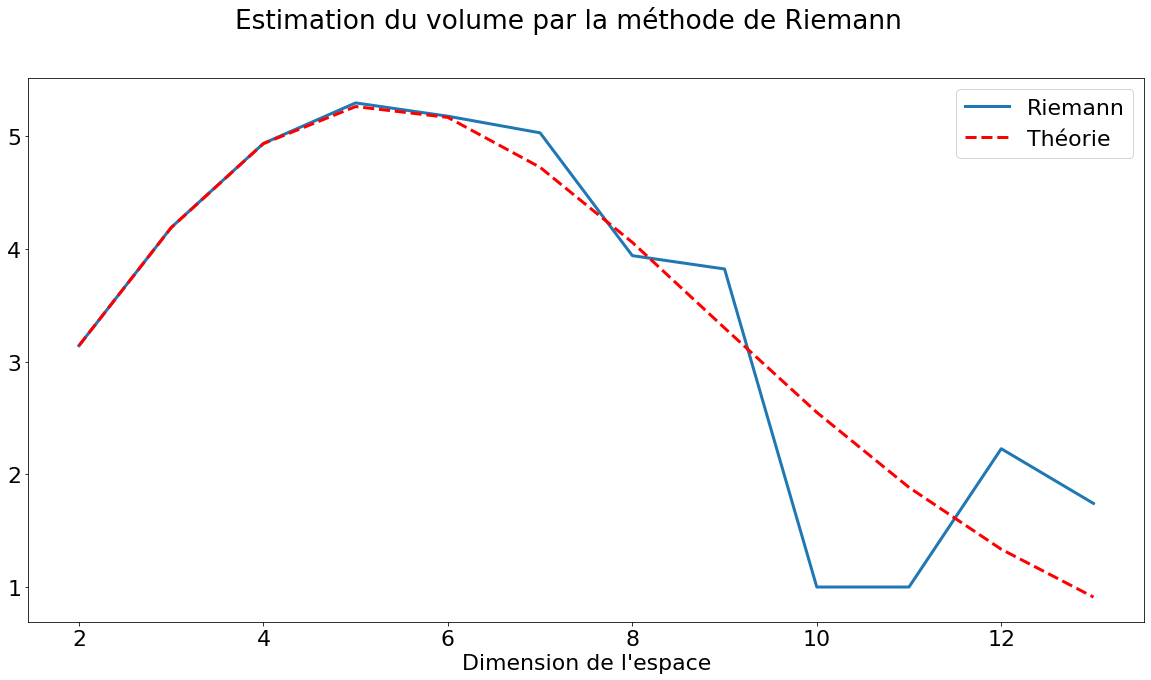

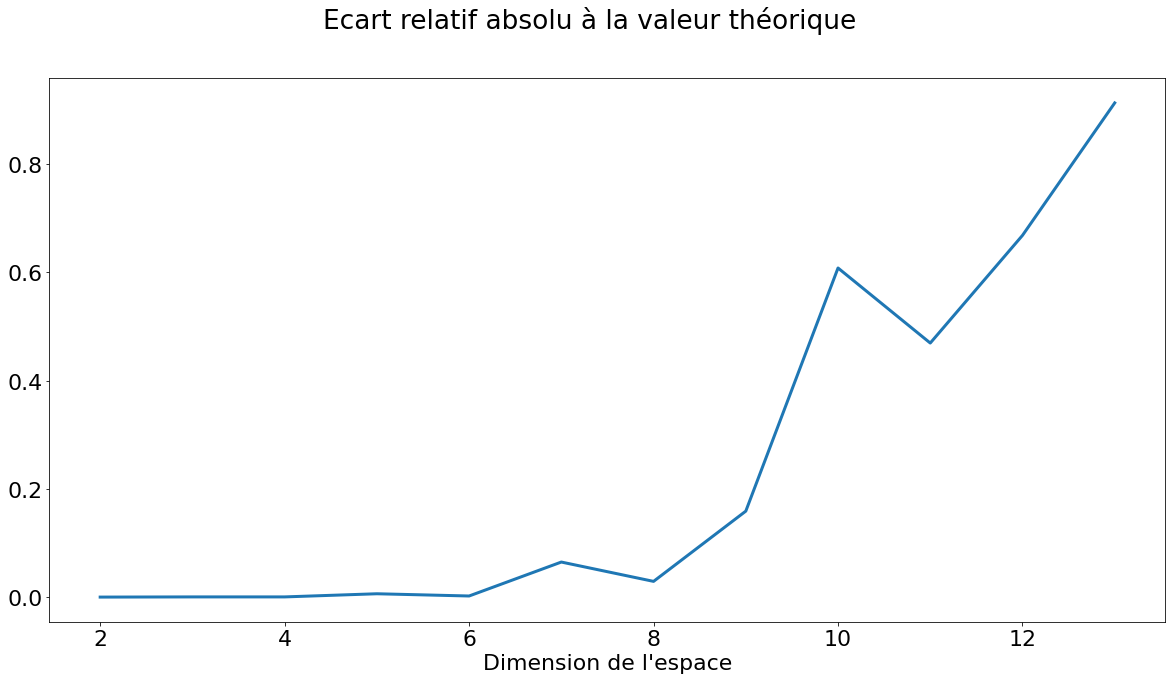

In [5]:

# Calculs des valeurs
est_Riemann = np.zeros([nb_dimensions,2])
val_th = np.zeros(nb_dimensions)
for i in range(nb_dimensions):
    dim = dimensions[i]
    print("Estimation par la méthode de Riemann en dimension",dim)
    val_th[i] = np.power(np.pi, dim/2)/special.gamma(dim/2 + 1)
    est_Riemann[i,:] = estimation_Riemann(dim, grille_Riemann(dim,N))

# Affichage
fig =plt.figure()
plt.plot(dimensions, est_Riemann[:,0], label="Riemann")
plt.plot(dimensions, val_th, 'r--', label="Théorie")
plt.legend()
fig.suptitle("Estimation du volume par la méthode de Riemann")
plt.xlabel("Dimension de l'espace")
plt.show()

fig = plt.figure()
plt.plot(dimensions, est_Riemann[:,1])
fig.suptitle("Ecart relatif absolu à la valeur théorique")
plt.xlabel("Dimension de l'espace")
plt.show()

<div class="alert alert-warning"><b>REPONSE A LA QUESTION I.1.</b> </div>

Lorsque $d$ augmente, la précision s'effondre, jusqu'à atteindre une erreur relative de plus de 80% en dimension 13 pour un échantillon de taille $5.10^6$. Cela est dû à l'approximation par des hypercubes qui devient moins précise.<br>
En augmentant $N$ on peut compenser les inexactitudes dans la méthode, mais le temps de calcul augmente en conséquence.

---

<p class="bg-primary" style="padding:1em"><b>QUESTION I.2.</b> Que calcule le code suivant ? Commentez la courbe obtenue.</p>

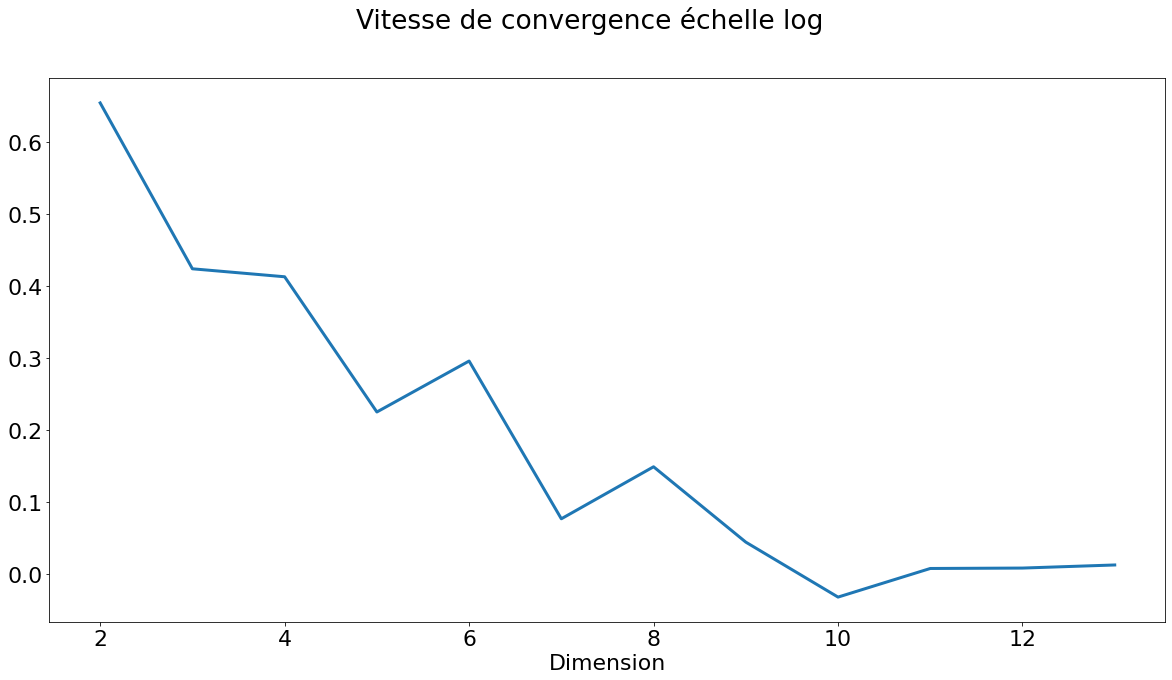

In [6]:
vitesse_R = np.zeros(nb_dimensions)
for i in range(nb_dimensions):
    dim = dimensions[i]
    vitesse_R[i] = -np.log(np.abs(est_Riemann[i,0] - val_th[i])) / np.log(N_effectif(dim, N))

plt.plot(dimensions, vitesse_R)


plt.suptitle("Vitesse de convergence échelle log")
plt.xlabel("Dimension")
plt.show()

<div class="alert alert-warning"><b>REPONSE A LA QUESTION I.2.</b> </div>

Ce code calcule le rapport entre le log de l'erreur relative et le log du nombre d'hypercubes dans la méthode de Riemann. Il nous permet de voir que la précision évolue en exponentielle décroissante de la taille de l'échantillon, et que la vitesse de convergence s'effondre donc bien avec l'augmentation de la dimension.
Quand la dimension augmente, augmenter la taille de l'échantillon augmente de moins en moins la précision.

---

On s'intéresse à la robustesse de l'estimation précédente. Pour cela, on considère
$$ \widehat V^{\text{Rc}}_d = \frac{2^d}{N} \sum_{k=1}^N f(c_k) $$
où $c_k$ est le coin de l'hypercube $k$, i.e., $c_k = x_k + \frac{\delta}{2} {\bf 1}$ avec ${\bf 1} = (1, \ldots, 1) \in R^n$.

<p class="bg-primary" style="padding:1em"><b>QUESTION I.3.</b> Définissez la fonction <code>estimation_Riemann_coin</code> afin qu'elle renvoie l'estimation et l'écart correspondant à cette nouvelle approximation. Rajoutez sur les courbes précédentes les résultats liés à cette estimation et commentez les résultats obtenus.</p>

In [7]:
def estimation_Riemann_coin(dim, grille):
    
    N = len(grille)
    delta = 2/pow(N, 1/dim)

    coins_grille = grille + delta/2 * np.ones((N, dim))

    return estimation_Riemann(dim, coins_grille)

Estimation par la méthode de Riemann en dimension 2
  - Taille d'echantillon ajustee pour la methode de Riemann: 4999696 au lieu de 5000000 (dimension = 2 )
Estimation par la méthode de Riemann en dimension 3
  - Taille d'echantillon ajustee pour la methode de Riemann: 4913000 au lieu de 5000000 (dimension = 3 )
Estimation par la méthode de Riemann en dimension 4
  - Taille d'echantillon ajustee pour la methode de Riemann: 4879681 au lieu de 5000000 (dimension = 4 )
Estimation par la méthode de Riemann en dimension 5
  - Taille d'echantillon ajustee pour la methode de Riemann: 4084101 au lieu de 5000000 (dimension = 5 )
Estimation par la méthode de Riemann en dimension 6
  - Taille d'echantillon ajustee pour la methode de Riemann: 4826809 au lieu de 5000000 (dimension = 6 )
Estimation par la méthode de Riemann en dimension 7
  - Taille d'echantillon ajustee pour la methode de Riemann: 4782969 au lieu de 5000000 (dimension = 7 )
Estimation par la méthode de Riemann en dimension 8
  - Ta

Text(0.5, 0, 'Dimension')

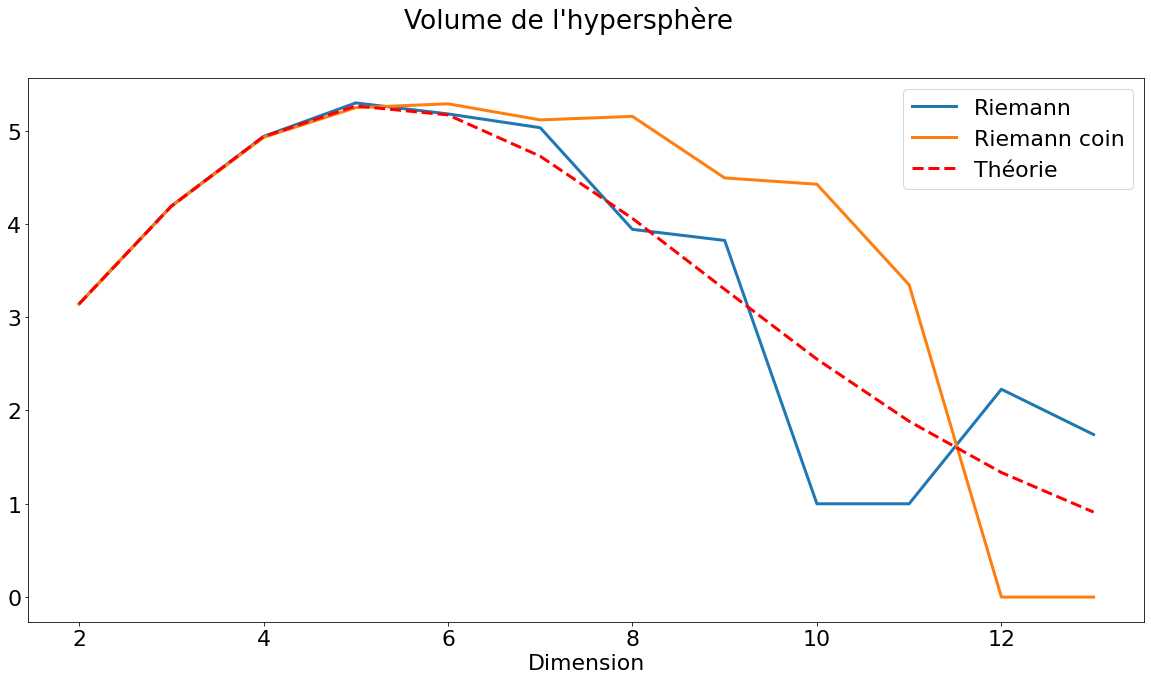

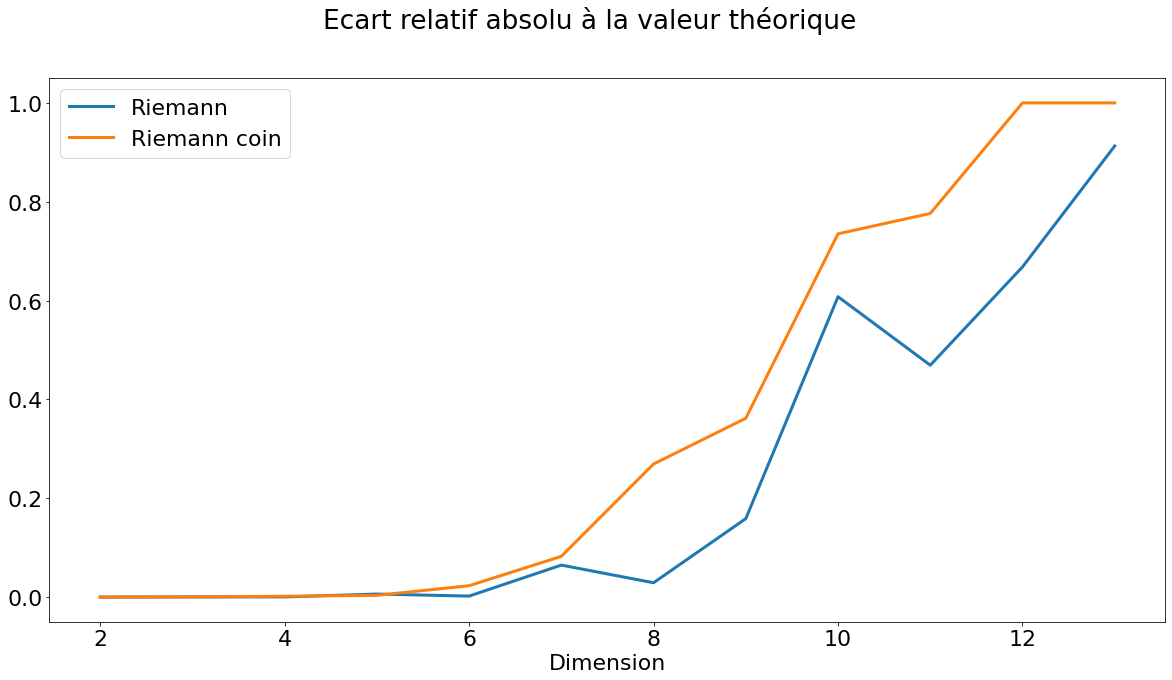

In [8]:
# Calculs des valeurs
est_Riemann = np.zeros([nb_dimensions,2])
est_Riemann_coin = np.zeros([nb_dimensions,2])
for i in range(nb_dimensions):
    dim = dimensions[i]
    print("Estimation par la méthode de Riemann en dimension",dim)
    grille = grille_Riemann(dim,N)
    val_th[i] = np.power(np.pi, dim/2)/special.gamma(dim/2 + 1)
    est_Riemann[i,:] = estimation_Riemann(dim, grille)
    est_Riemann_coin[i,:] = estimation_Riemann_coin(dim, grille)

# Affichage
fig = plt.figure()
plt.plot(dimensions, est_Riemann[:,0], label="Riemann")
plt.plot(dimensions, est_Riemann_coin[:,0], label="Riemann coin")
plt.plot(dimensions, val_th, 'r--', label="Théorie")
plt.legend()
fig.suptitle("Volume de l'hypersphère")
plt.xlabel("Dimension")

fig = plt.figure()
plt.plot(dimensions, est_Riemann[:,1], label="Riemann")
plt.plot(dimensions, est_Riemann_coin[:,1], label="Riemann coin")
plt.legend()
fig.suptitle("Ecart relatif absolu à la valeur théorique")
plt.xlabel("Dimension")

<div class="alert alert-warning"><b>REPONSE A LA QUESTION I.3.</b> </div>

L'estimation par la méthode de Riemann n'est pas très robuste : en décalant légèrement la grille, la précision diminue de près de 20% à partir de la dimension 8, et dès la dimension 9, l'estimation est nulle.

---

<p class="bg-primary" style="padding:1em"><b>QUESTION I.4.</b>

 Soit $V^-_d$ le volume de la sphère de rayon $1 - K/d$ en dimension $d$ : montrez théoriquement que $V_d - V^-_d \sim (1-e^{-K}) V_d$ lorsque $d \to \infty$, et utilisez ce résultat pour interpréter les résultats précédents.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION I.4.</b> </div>
On a :

$$V_d - V^-_d = \frac{\pi^{d/2}}{\Gamma (d/2 + 1)} - \frac{\pi^{d/2}(1 - K/d)^d}{\Gamma (d/2 + 1)} = V_d \left(1 - \left(1 - \frac{K}{d}\right)^d\right)$$
On procède donc à un développement limité de la quantité $\displaystyle \left(1-\frac{K}{d} \right)^d$ :
$$\left( 1 - \frac{K}{d} \right)^d = \exp \left( d \cdot \ln \left( 1 - \frac{K}{d} \right) \right) \underset{+\infty}{=} \exp \left( -K - \frac{K^2}{2d} + o \left( \frac{1}{d^2}\right) \right) = e^{-K} \left(1 - \frac{K^2}{2d} + o \left( \frac{1}{d} \right) \right)$$
Finalement on trouve :

$$1 - \left( 1 - \frac{K}{d} \right)^d \underset{+ \infty}{=} 1 - e^{-K} + \frac{K^2}{2d}e^{-K} + o \left(\frac{1}{d} \right) \underset{+ \infty}{\sim} 1 - e^{-K}$$

L'équivalent donne donc :
$$V_d - V_d^- \underset{+\infty}{\sim} \left(1- e^{-K}\right) V_d$$

---

<p class="bg-primary" style="padding:1em">

<b>$\star$ QUESTION I.5 $\star$.</b> Quel bilan tirez-vous de l'estimation d'intégrales par somme de Riemann? </p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION I.5.</b> </div>

Cette méthode convient bien à des petites dimensions, et présente de plus l'avantage d'être simple à implémenter.

Cependant, rapidement atteindre une précision suffisante nécessite d'augmenter drastiquement le nombre de subdivisions, ce qui est très coûteux. De plus, cette méthode n'est pas très robuste.

<a id="MC"></a><h1 style="border: 5px solid; text-align: center; padding: 10px">II. Introduction à la méthode de Monte-Carlo : le cas IID</h1>

<div class="alert alert-success">On introduit maintenant la méthode de Monte-Carlo sur le même problème d'estimation du volume de la sphère et on discute sa vitesse de convergence.<br>
<b>Rappel</b> i.i.d. = indépendantes et identiquement distribuées</div>

<h2>II.1. Méthode de Monte-Carlo</h2>

Soit $(X_k, k \geq 1)$ des variables i.i.d. uniformément réparties sur $[-1,1]^d$ et
$$ \widehat V^{\text{MC}}_d = \frac{2^d}{N} \sum_{k=1}^N f(X_k). $$

<p class="bg-primary" style="padding:1em"><b>QUESTION II.1.1.</b> 

Donnez la densité de $X_1$ et justifiez que $\widehat V^{\text{MC}}_d \to V_d$ lorsque $N \to \infty$.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION II.1.1.</b> </div>

$X_1$ est suit une loi continue, donc sa densité de probabilité est l'inverse de son volume, fois l'indicatrice de l'intervalle, soit $f_{X_1}(x) = \frac{\mathbb{1} (x \in [-1,1]^d ) }{2^d}$

Les variables $X_i$ étant iid, on a d'après la loi des grands nombres :
$$ \frac{2^d}{N} \sum_{k=1}^N f(X_k) \underset{N \to \infty}{\to} 2^dE[f(X_1)]$$

Or : $$E[f(X_1)] = \int f(x)f_{X_1}(x)dx = \int_{[-1, 1]^d} \frac{f(x)}{2^d} dx = \frac{V_d}{2^d}$$

Et on trouve bien que $\widehat V^{\text{MC}}_d \to V_d$ lorsque $N \to \infty$

---

<p class="bg-primary" style="padding:1em"><b>QUESTION II.1.2.</b> 

Complétez la fonction <code>estimation_IIDMC</code> afin d'ajouter aux courbes précédentes l'évolution de $\widehat V^{\text{MC}}_d$ ainsi que l'écart relatif correspondant. Commentez les courbes obtenues.</p>

In [9]:
def estimation_IIDMC(dim, taille_echantillon):
    """
    Calcule l'approximation du volume de la sphére en dimension
    dim à l'aide de la méthode de Monte-Carlo
    """
    estimation = 2**dim * np.sum(np.linalg.norm(np.random.uniform(high=1., low=-1., size =[taille_echantillon, dim]), axis=1) <= 1) / taille_echantillon
    volume_vrai = pow(np.pi, dim/2) / special.gamma(dim/2 + 1)
    ecart_relatif = estimation/volume_vrai-1
    erreur_relative = np.sqrt(2**dim / volume_vrai - 1)/np.sqrt(taille_echantillon)
    return [estimation, ecart_relatif, erreur_relative]

Estimation par Monte Carlo en dimension: 2
Estimation par Monte Carlo en dimension: 3
Estimation par Monte Carlo en dimension: 4
Estimation par Monte Carlo en dimension: 5
Estimation par Monte Carlo en dimension: 6
Estimation par Monte Carlo en dimension: 7
Estimation par Monte Carlo en dimension: 8
Estimation par Monte Carlo en dimension: 9
Estimation par Monte Carlo en dimension: 10
Estimation par Monte Carlo en dimension: 11
Estimation par Monte Carlo en dimension: 12
Estimation par Monte Carlo en dimension: 13


Text(0.5, 0, 'Dimension')

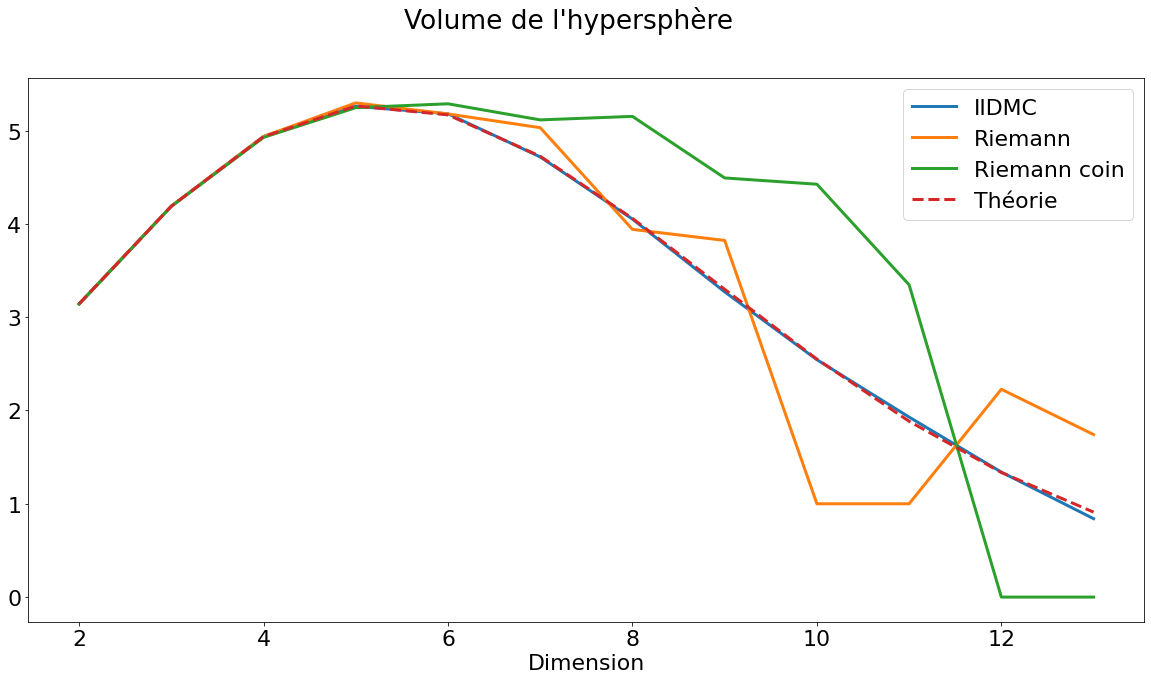

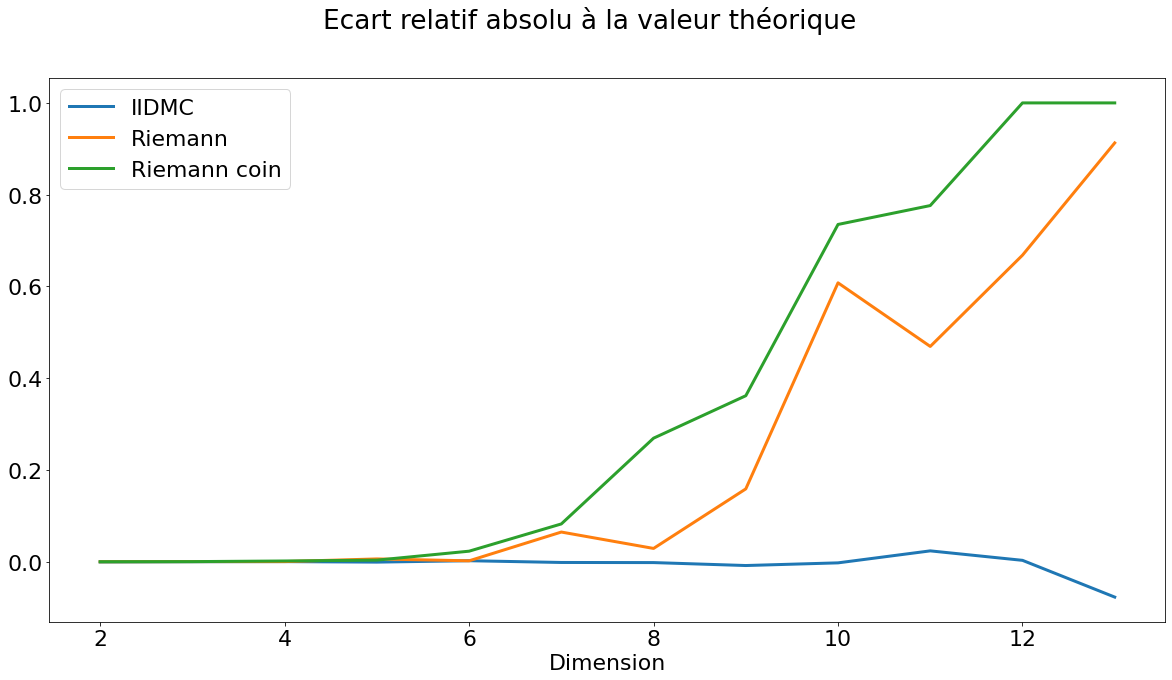

In [10]:
# Calculs des valeurs
est_IIDMC = np.zeros([nb_dimensions,3])
for i in range(nb_dimensions):
    dim = dimensions[i]
    print("Estimation par Monte Carlo en dimension:",dim)
    # pour une comparaison juste, on prend la même taille d'échantillon que pour Riemann
    est_IIDMC[i,:] = estimation_IIDMC(dim, N)

# Affichage
fig = plt.figure()
plt.plot(dimensions, est_IIDMC[:,0], label="IIDMC")
plt.plot(dimensions, est_Riemann[:,0], label="Riemann")
plt.plot(dimensions, est_Riemann_coin[:,0], label="Riemann coin")
th, = plt.plot(dimensions, val_th, '--', label="Théorie")
plt.legend()
fig.suptitle("Volume de l'hypersphère")
plt.xlabel("Dimension")

fig = plt.figure()
plt.plot(dimensions, est_IIDMC[:,1], label="IIDMC")
plt.plot(dimensions, est_Riemann[:,1], label="Riemann")
plt.plot(dimensions, est_Riemann_coin[:,1], label="Riemann coin")
plt.legend()
fig.suptitle("Ecart relatif absolu à la valeur théorique")
plt.xlabel("Dimension")

<div class="alert alert-warning"><b>REPONSE A LA QUESTION II.1.2.</b> </div>

Les résultats obtenus sont bien plus précis, même aux grandes dimensions.

<p class="bg-primary" style="padding:1em"><b>QUESTION II.1.3.</b> Faites tourner le script suivant et commentez les résultats obtenus.</p>

Text(0.5, 0, 'Dimension')

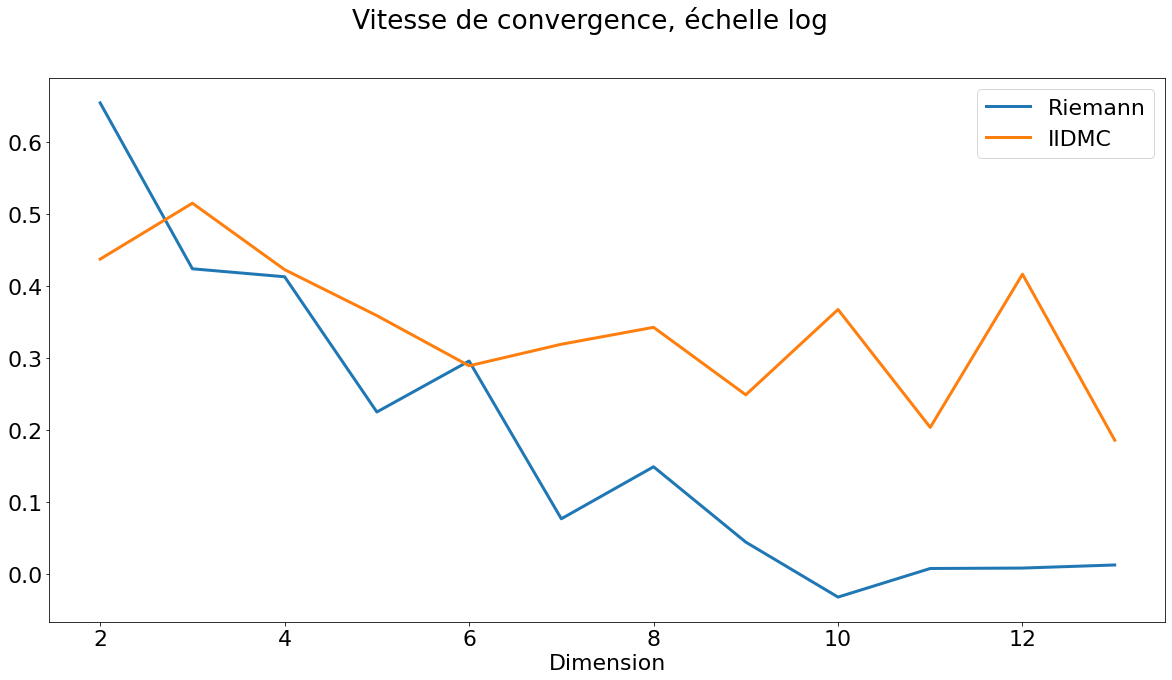

In [11]:
vitesse_IIDMC = np.zeros(nb_dimensions)
for i in range(nb_dimensions):
    dim = dimensions[i]
    vitesse_IIDMC[i] = -np.log(np.absolute(est_IIDMC[i,0] - val_th[i])) / np.log(N_effectif(dim, N))
fig = plt.figure()
plt.plot(dimensions, vitesse_R, label="Riemann")
plt.plot(dimensions, vitesse_IIDMC, label="IIDMC")
plt.legend()
fig.suptitle("Vitesse de convergence, échelle log")
plt.xlabel("Dimension")

<div class="alert alert-warning"><b>REPONSE A LA QUESTION II.1.3.</b> </div>

Contrairement aux méthodes de Riemann, la vitesse de convergence de la méthode de Monte-Carlo ne dépend pas de la dimension du problème. La baisse de la précision avec la dimension est dûe à la baisse de la valeur de l'intégrale, qui devient naturellement plus dure à estimer.

On constate aussi que la méthode de Riemann est plus préise aux faibles dimensions (1 et 2)

---
<p class="bg-primary" style="padding:1em">

<b>QUESTION II.1.4.</b> Quelle est la vitesse de convergence théorique de l'estimateur $\widehat V^{MC}_d$? Comparez les vitesses de convergence entre méthode de Monte-Carlo et méthode de Riemann</p>

<div class="alert alert-warning">
<b>REPONSE A LA QUESTION II.1.4.</b> </div>

Grâce au théorème central limite, on peut écrire que : 
$\widehat V^{MC}_d - V_d \approx \frac{Y \sqrt{Var(X_1)N}}{N} $
où $Y$ suit une loi normale standard, donc bornée, et on trouve une convergence en l'inverse de la racine carré du nombre d'échantillon.

En comparaison, la méthode de Riemann converge en $N^{-\frac{1}{d}}$ : la convergence de la méthode de Monte-Carlo est donc meilleur dès que la dimension est supérieure à 2.

---

<p class="bg-primary" style="padding:1em">

<b>QUESTION II.1.5.</b> On fixe la dimension $d = 15$. Répétez l'expérience plusieurs fois : l'estimation donnée par $\widehat V^{\text{MC}}_d$ est-elle stable ? Et la vitesse de convergence ? Commentez les résultats obtenus et notamment l'influence de $N$.</p>

In [12]:
nb_repet = 10**1
dim = 15
estim = np.zeros(nb_repet)
vitesse = np.zeros(nb_repet)
val_th = np.zeros(nb_repet) + np.pi**(dim/2) / special.gamma(dim/2+1)
for i in range(nb_repet):
    print("Itération {} / {}".format(i+1, nb_repet))
    estim[i] = estimation_IIDMC(dim, N)[0]
    vitesse[i] = -np.log(np.absolute(estim[i] - val_th[i])) / np.log(N)

Itération 1 / 10
Itération 2 / 10
Itération 3 / 10
Itération 4 / 10
Itération 5 / 10
Itération 6 / 10
Itération 7 / 10
Itération 8 / 10
Itération 9 / 10
Itération 10 / 10


Text(0.5, 0.98, 'Estimation du volume en dimension 15')

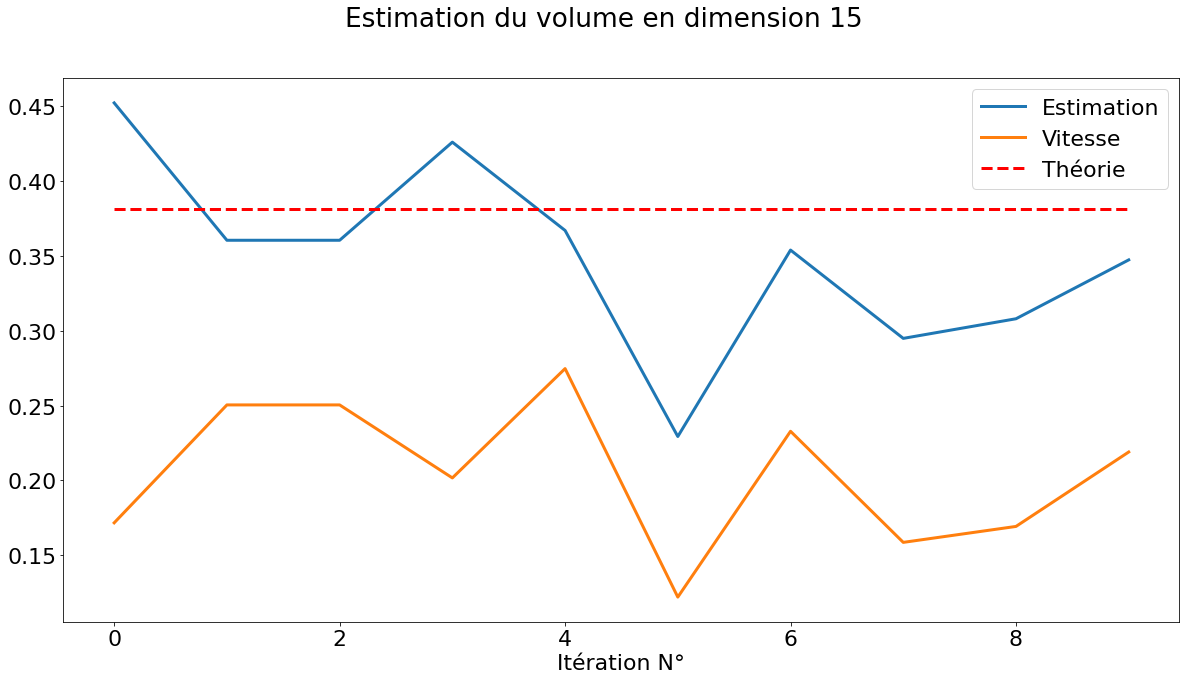

In [13]:
plt.plot(range(nb_repet), estim, label="Estimation")
plt.plot(range(nb_repet), vitesse, label="Vitesse")
plt.plot(range(nb_repet), val_th, 'r--', label="Théorie")
plt.xlabel("Itération N°")
plt.legend()
plt.suptitle("Estimation du volume en dimension 15")

<div class="alert alert-warning"><b>REPONSE A LA QUESTION II.1.5.</b> </div>

On constate que la vitesse est bien la même pour un nombre fixé d'itération, à des fluctuations aléatoires près (correspondant à la loi normale dans le théorème central limite), et que l'estimation fluctue autour de la valeur théorique.



<h2>II.2. Précision d'un estimateur</h2>

Le but de cette partie est de montrer que la variance n'est toujours pas une mesure satisfaisante pour mesurer la précision d'un estimateur. On considère pour cela la fonction $p(t) = P(\lVert X \rVert \leq t)$ où $X$ est uniformément répartie sur $[-1,1]^d$.

<p class="bg-primary" style="padding:1em">

<b>QUESTION II.2.1</b> 
Donnez l'estimateur de Monte-Carlo de $p(t)$, que l'on notera $\widehat{p}(t)$, ainsi que son espérance et sa variance. En déduire que $\frac{1}{N} (\widehat p(t) - \widehat p(t)^2)$ est un estimateur de la variance de $\widehat p(t)$.</p>

<div class="alert alert-warning">

<b>REPONSE A LA QUESTION II.2.1.</b>
On a $p(t) = P(||X||\leq t)$<br>

On en déduit l'estimateur $\displaystyle \widehat{p}(t) = \frac{1}{N} \sum_{k=1}^N \textbf{1}\{ \Vert X \Vert \leq t \}$ <br>

On va maintenant calculer l'espérance de cet estimateur :
$$\mathbb{E}( \hat{p}(t)) = \frac{1}{N} \sum_{k=1}^N \underbrace{\mathbb{E} ( \textbf{1} \{ \Vert X_k \Vert \leq t \})}_{p(t)} \underset{i.i.d}{=} p(t)$$

On a $\mathbb{E}(\hat{p}(t)) = p(t)$, on a ainsi un <b>estimateur sans biais</b>.

Pour la variance :
$$\mathbb{V}(\hat{p}(t) \underset{i.i.d}{=} \frac{1}{N^2} \sum_{k=1}^N \mathbb{V} \underbrace{(\textbf{1} \{ \Vert X_k \Vert \leq t\})}_{\hookrightarrow \mathcal{B}(p(t))} = \frac{1}{N^2} \sum_{k=1}^N p(t)(1-p(t))$$

D'où $\displaystyle \mathbb{V}(\hat{p}(t)) = \frac{p(t)-p(t)^2}{N}$

Alors naturellement, $\hat{p}(t)$ étant un bon estimateur de $p(t)$, on peut estimer la variance de $\hat{p}(t)$ par  $\displaystyle \boxed{\frac{1}{N} \left( \hat{p}(t) - \hat{p}(t)^2 \right)}$
</div>

<p class="bg-primary" style="padding:1em"><b>QUESTION II.2.2.</b>

Complétez le script suivant afin de tracer $t \mapsto \widehat p(t) - \widehat p(t)^2$. Pour quelle valeur de $t$ l'estimateur vous semble-t-il être le moins précis ?</p>

Text(0.5, 0.98, "Precision de l'estimateur")

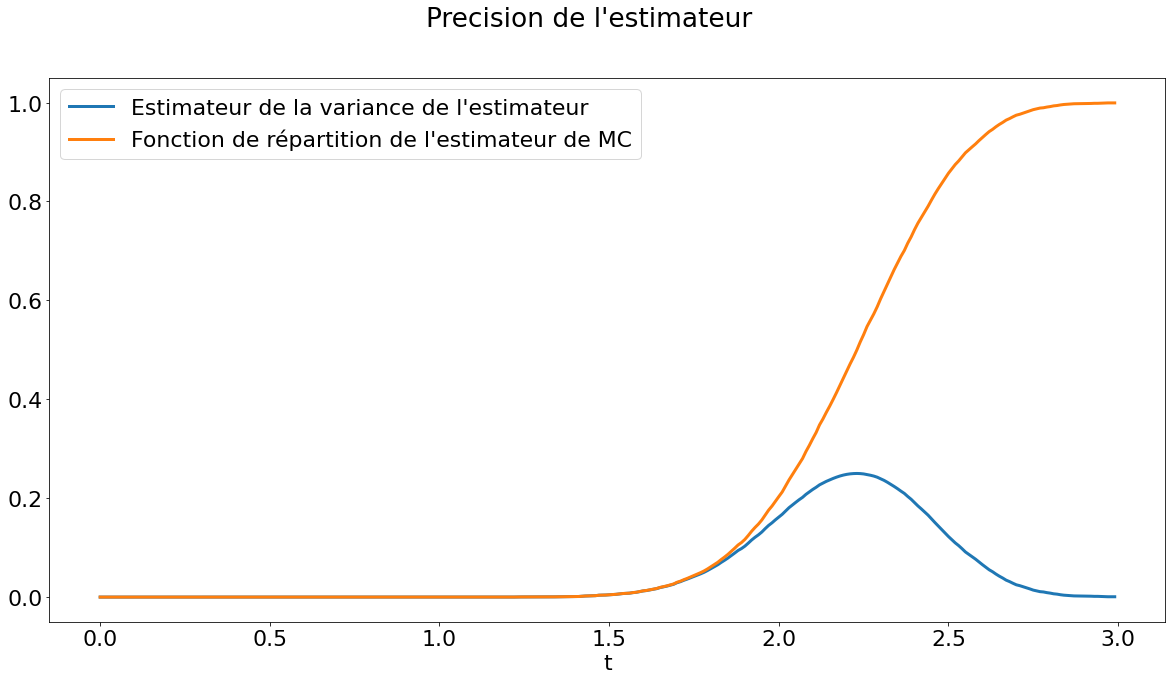

In [14]:
taille_echantillon = 10**4
dim = 15
echantillon = np.random.uniform(-1., 1., [taille_echantillon, dim])
valeurs_t = np.arange(0,3,.01)
estimation_p = np.zeros(len(valeurs_t))
for i in range(len(valeurs_t)):
    estimation_p[i] = np.sum(np.linalg.norm(echantillon, axis=1) <= valeurs_t[i])/taille_echantillon
plt.xlabel("t")
plt.plot(valeurs_t, estimation_p - np.power(estimation_p,2), label="Estimateur de la variance de l'estimateur")
plt.plot(valeurs_t, estimation_p, label="Fonction de répartition de l'estimateur de MC")

plt.legend()
plt.xlabel("t")
plt.suptitle("Precision de l'estimateur")

<div class="alert alert-warning"><b>REPONSE A LA QUESTION II.2.2.</b> </div>

L'estimateur semble être le moins précis pour $t \approx 2,5$

<p class="bg-primary" style="padding:1em">

<b>QUESTION II.2.3.</b> Justifiez le choix de
$$ \frac{\sqrt{\widehat p(t) - \widehat p(t)^2}}{\widehat p(t)} $$
pour évaluer la précision de $\widehat p(t)$.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION II.2.3.</b> </div>

C'est un estimateur de la variance.

---

<div class="alert alert-success center;">

On définit l'<b>erreur relative</b> comme le rapport entre l'écart-type de l'estimateur et sa moyenne :
$$ \text{erreur relative} = \frac{\sqrt{\text{Var}(\widehat V)}}{E (\widehat V)} $$
En pratique, ces valeurs sont inconnues mais on peut les estimer par Monte-Carlo.</div>

<p class="bg-primary" style="padding:1em">

<b>QUESTION II.2.4.</b> Reprenez et complétez le script précédent afin de tracer, sur une autre figure, la courbe $t \mapsto \sqrt{1/\widehat p(t) - 1}$. Pour quelles valeurs de $t$ l'estimateur vous semble-t-il être le moins précis ?</p>

/tmp/ipykernel_45374/1197914575.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(valeurs_t, np.sqrt(1/estimation_p-1), label="Erreur relative de l'estimateur")


Text(0.5, 0.98, '$\\sqrt{1/\\hat{p} - 1}$')

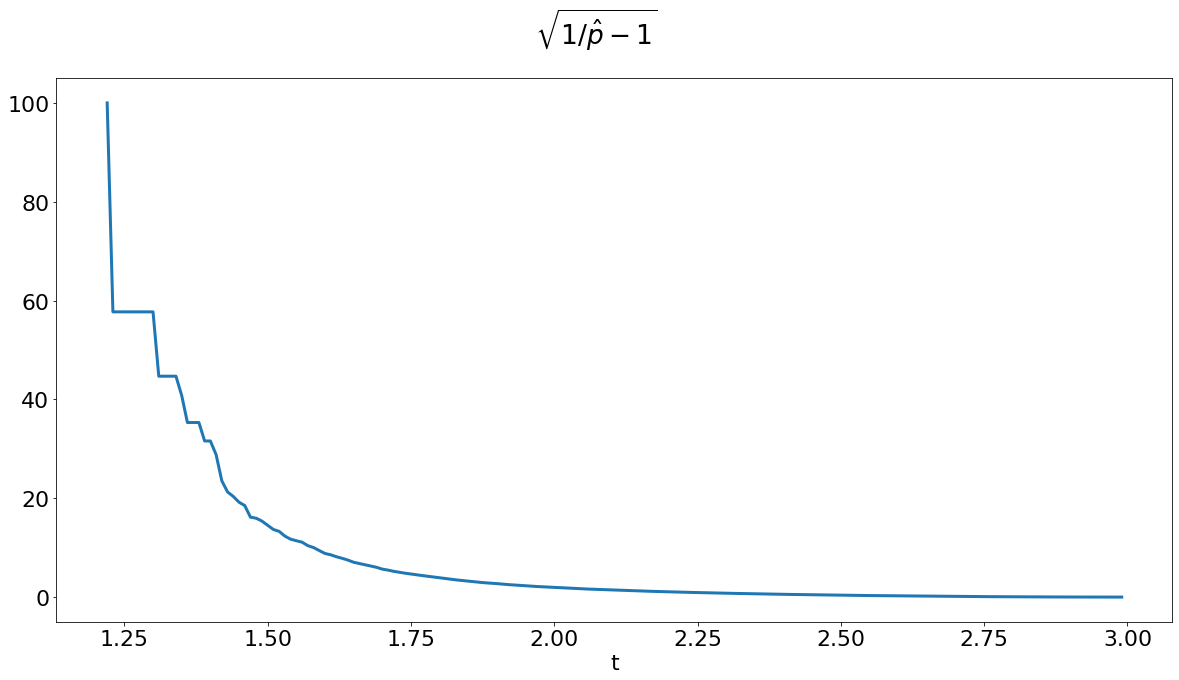

In [18]:
plt.xlabel("t")
plt.plot(valeurs_t, np.sqrt(1/estimation_p-1), label="Erreur relative de l'estimateur")
plt.suptitle(r"$\sqrt{1/\hat{p} - 1}$")

<div class="alert alert-warning"><b>REPONSE A LA QUESTION II.2.4.</b> </div>

On revient maintenant au cas de la sphère.

<p class="bg-primary" style="padding:1em">

<b>$\star$ QUESTION II.2.5. $\star$</b> Montrez que dans ce cas, l'erreur relative de l'estimateur de Monte-Carlo est donnée par
$$ \frac{\sqrt{\text{Var}(\widehat V^{\text{MC}}_d)}}{E(\widehat V^{\text{MC}}_d)} = \frac{c_d}{\sqrt N} \ \text{ avec } \ c_d = \sqrt{\frac{2^d}{V_d}-1}. $$
</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION II.2.5.</b> </div>

<p class="bg-primary" style="padding:1em"><b>QUESTION II.2.6.</b> Modifiez la fonction <code>estimation_IIDMC</code> de telle sorte à ce qu'elle calcule également l'erreur relative d'estimation du volume de la sphère. Tracez la courbe correspondante et commentez les résultats obtenus.</p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION II.2.6.</b> </div>

L'erreur relative augmente avec la dimension, car la taille de l'intégrale diminue beaucoup quand la dimension augmente.

Estimation par Monte Carlo en dimension: 2
Estimation par Monte Carlo en dimension: 3
Estimation par Monte Carlo en dimension: 4
Estimation par Monte Carlo en dimension: 5
Estimation par Monte Carlo en dimension: 6
Estimation par Monte Carlo en dimension: 7
Estimation par Monte Carlo en dimension: 8
Estimation par Monte Carlo en dimension: 9
Estimation par Monte Carlo en dimension: 10
Estimation par Monte Carlo en dimension: 11
Estimation par Monte Carlo en dimension: 12
Estimation par Monte Carlo en dimension: 13


Text(0.5, 0, 'Dimension')

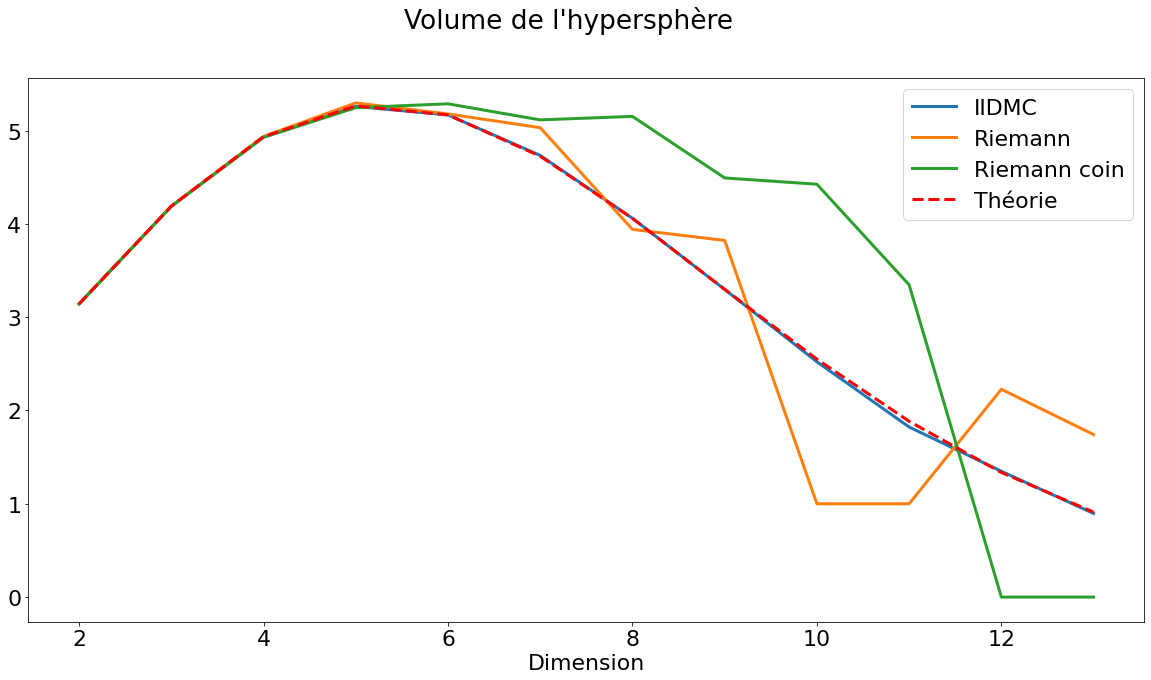

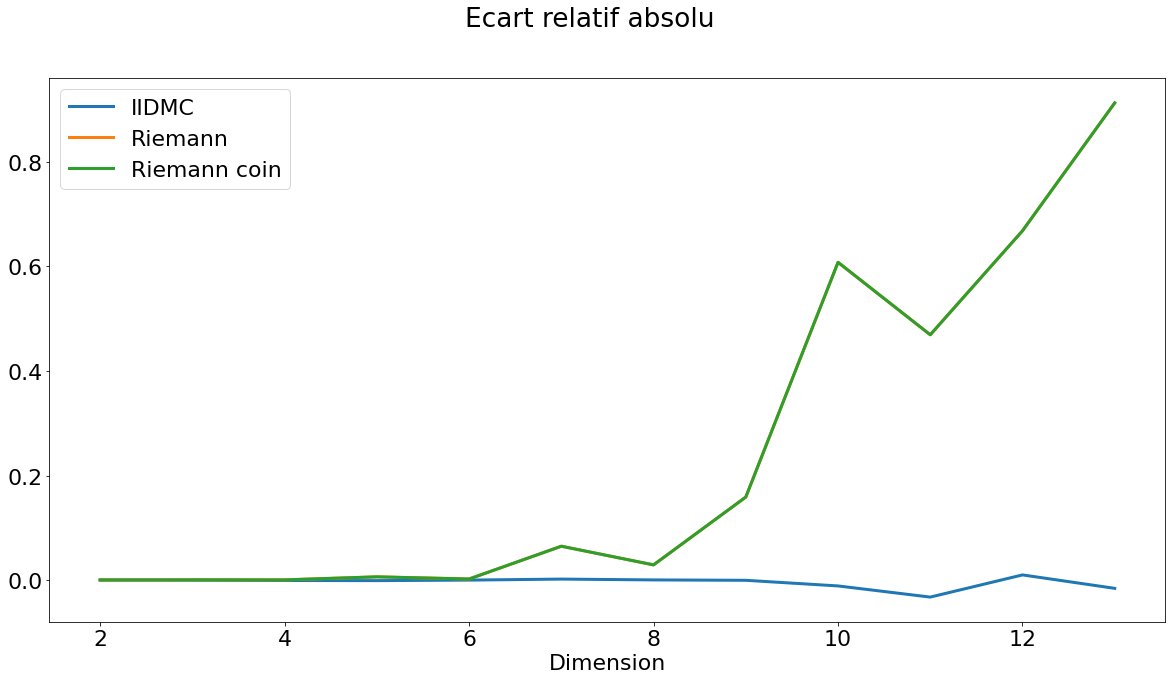

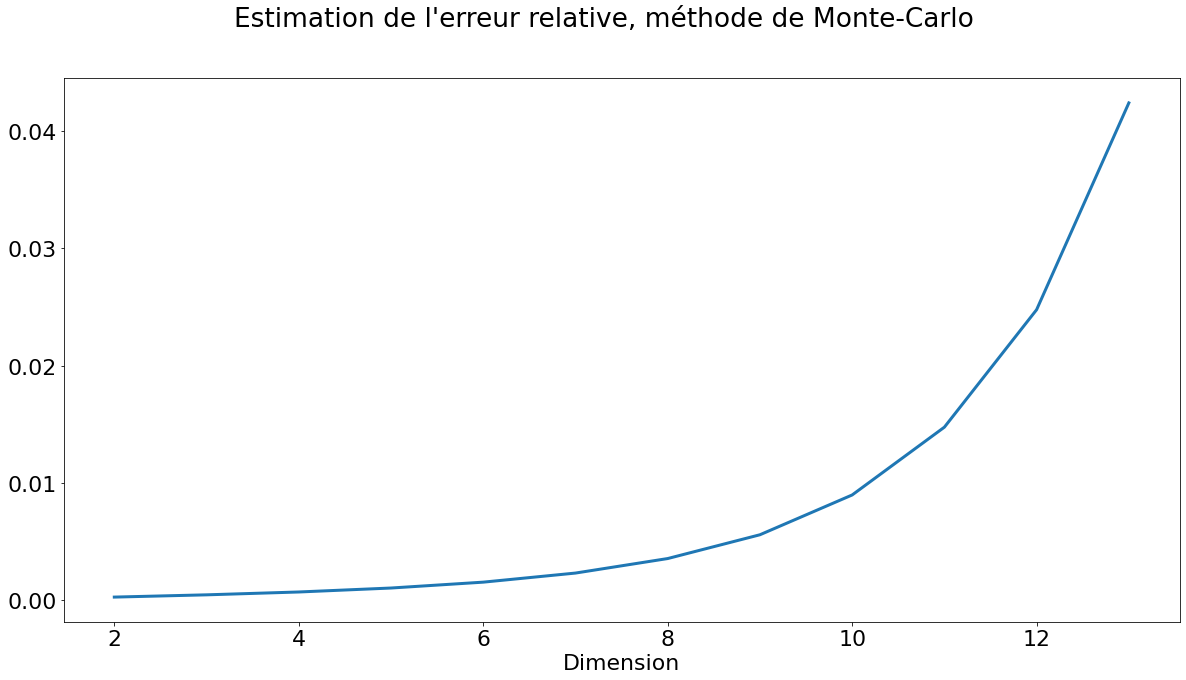

In [16]:
# Calculs des valeurs
est_IIDMC = np.zeros([nb_dimensions,3])
val_th = np.zeros(nb_dimensions)
for i in range(nb_dimensions):
    dim = dimensions[i]
    val_th[i] = np.pi**(dim/2) / special.gamma(dim/2+1) 
    print("Estimation par Monte Carlo en dimension:",dim)
    # pour une comparaison juste, on prend la même taille d'échantillon que pour Riemann
    est_IIDMC[i,:] = estimation_IIDMC(dim, N)

# Affichage
fig = plt.figure()
plt.plot(dimensions, est_IIDMC[:,0], label="IIDMC")
plt.plot(dimensions, est_Riemann[:,0], label="Riemann")
plt.plot(dimensions, est_Riemann_coin[:,0], label="Riemann coin")
plt.plot(dimensions, val_th, 'r--', label="Théorie")
plt.legend()
fig.suptitle("Volume de l'hypersphère")
plt.xlabel("Dimension")

fig = plt.figure()
plt.plot(dimensions, est_IIDMC[:,1], label="IIDMC")
plt.plot(dimensions, est_Riemann[:,1], label="Riemann")
plt.plot(dimensions, est_Riemann[:,1], label="Riemann coin")
plt.legend()
fig.suptitle("Ecart relatif absolu")
plt.xlabel("Dimension")

fig = plt.figure()
errel_IIDMC, = plt.plot(dimensions, est_IIDMC[:,2])
fig.suptitle("Estimation de l'erreur relative, méthode de Monte-Carlo")
plt.xlabel("Dimension")

<h2>II.3. Limitations de la méthode IIDMC</h2>

On conclut cette partie par une limitation évidente de la méthode de Monte-Carlo.

<p class="bg-primary" style="padding:1em">

<b>QUESTION II.3.1.</b> Que vaut $\widehat V^{\text{MC}}_{30}$ pour $N = 10^6$? Faites un calcul d'ordre de grandeur pour déterminer le nombre d'échantillons qu'il faudrait pour avoir une erreur relative $\leq 10^{-2}$.</p>

In [17]:
N = 10**6
dim = 30
print(estimation_IIDMC(dim, N))

[0.0, -1.0, 6999.639855271593]


<div class="alert alert-warning"><b>REPONSE A LA QUESTION II.3.1.</b> </div>

Il faudrait environ $10^{18}$ échantillon, ce qui n'est pas réalisable.

<p class="bg-primary" style="padding:1em">

<b>QUESTION II.3.2.</b> Pour quelle raison la méthode de Monte-Carlo n'est pas efficace pour estimer $\widehat V^{\text{MC}}_{30}$? Est-ce liée au fait que l'intégrale à estimer soit de dimension 30?

<div class="alert alert-warning"

><b>REPONSE A LA QUESTION II.3.2.</b> </div>
La méthode n'est pas efficace car la valeur de l'intégrale est très faible : $10^{-5}$. Or, avec notre méthode de Monte-Carlo, on échantillone de manière uniforme sur l'hypercube de -1 à 1, et on "rate" l'essentiel de la sphère, qui se concentre dans une partie de l'espace de plus en plus petite, en effet le volume de l'hypersphère, relatif à son cube conscrit est de plus en plus, petit.

<p class="bg-primary" style="padding:1em">

<b>$\star$ QUESTION II.3.3. $\star$</b> Quel bilan tirez-vous de l'estimation d'intégrales par méthode de Monte-Carlo? </p>

<div class="alert alert-warning"><b>REPONSE A LA QUESTION II.3.3.</b> </div>

Les méthodes de Monte-Carlo sont de bonnes solutions pour estimer des intégrales, mais sont dépendantes du choix du tirage des points.

<div class="alert alert-danger">

<b>On a illustré ci-dessus la méthode de Monte-Carlo sur l'exemple du calcul de l'intégrale
$$ \int_{[-1,1]^d} \phi(x) d x \ {\bf {\text{ avec }}} \ \phi(x) = {\bf 1}(\lVert x \rVert \leq 1). $$
L'idée a été d'interpréter l'intégrale comme une espérance et d'utiliser la loi forte des grands nombres pour approcher cette espérance. Cette idée se généralise aisément au calcul de l'intégrale
$$ \int \phi(x) f(x) d x $$
où $f$ est une densité, en réécrivant cette intégrale comme l'espérance de la variable aléatoire $\phi(X)$ où $X$ est de densité $f$. Par ailleurs, contrairement au cas déterministe, la vitesse de convergence de cette méthode est indépendante de la dimension du problème!</b></div>

